# LangChain with Open Source LLM and Open Source Embeddings & LangSmith

In the following notebook we will dive into the world of Open Source models hosted on Hugging Face's [inference endpoints](https://ui.endpoints.huggingface.co/).

The notebook will be broken into the following parts:

- 🤝 Breakout Room #1:
  1. Set-up Hugging Face Infrence Endpoints
  2. Install required libraries
  3. Set Environment Variables
  4. Testing our Hugging Face Inference Endpoint
  5. Creating LangChain components powered by the endpoints
  6. Retrieving data from Arxiv
  7. Creating a simple RAG pipeline with [LangChain v0.1.0](https://blog.langchain.dev/langchain-v0-1-0/)
  

- 🤝 Breakout Room #2:
  1. Set-up LangSmith
  2. Creating a LangSmith dataset
  3. Creating a custom evaluator
  4. Initializing our evaluator config
  5. Evaluating our RAG pipeline

# 🤝 Breakout Room #1

## Task 1: Set-up Hugging Face Infrence Endpoints

Please follow the instructions provided [here](https://github.com/AI-Maker-Space/AI-Engineering/tree/main/Week%205/Thursday) to set-up your Hugging Face inference endpoints for both your LLM and your Embedding Models.

## Task 2: Install required libraries

Now we've got to get our required libraries!

We'll start with our `langchain` and `huggingface` dependencies.



In [90]:
%pip install langchain langchain-core langchain-community langchain_openai huggingface-hub requests -q -U

Note: you may need to restart the kernel to use updated packages.


Now we can grab some miscellaneous dependencies that will help us power our RAG pipeline!

In [91]:
%pip install arxiv pymupdf faiss-cpu -q -U

Note: you may need to restart the kernel to use updated packages.


## Task 3: Set Environment Variables

We'll need to set our `HF_TOKEN` so that we can send requests to our protected API endpoint.

We'll also set-up our OpenAI API key, which we'll leverage later.



In [92]:
import os
import getpass

os.environ["HF_TOKEN"] = getpass.getpass("HuggingFace Write Token: ")

In [93]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Task 4: Testing our Hugging Face Inference Endpoint

Let's submit a sample request to the Hugging Face Inference endpoint!

In [94]:
model_api_gateway = "https://aavyrh83mancnlpt.us-east-1.aws.endpoints.huggingface.cloud" # << YOUR ENDPOINT URL HERE

> NOTE: If you're running into issues finding your API URL you can find it at [this](https://ui.endpoints.huggingface.co/) link.

Here's an example:

![image](https://i.imgur.com/xSCV0xM.png)

In [124]:
import requests

max_new_tokens = 256
top_p = 0.9
temperature = 0.1

prompt = "Hello! How are you?"

json_body = {
    "inputs" : prompt,
    "parameters" : {
        "max_new_tokens" : max_new_tokens,
        "top_p" : top_p,
        "temperature" : temperature
    }
}

headers = {
  "Authorization": f"Bearer {os.environ['HF_TOKEN']}",
  "Content-Type": "application/json"
}

response = requests.post(model_api_gateway, json=json_body, headers=headers)
print(response.json())

[{'generated_text': " I'm doing well, thanks for asking! *smiling*\n\nI hope you're having a great day and enjoying the beautiful weather. *winking*\n\nI just wanted to reach out and say hello, and see how you're doing. It's always nice to connect with someone new. *nodding*\n\nSo, tell me a little bit about yourself. What do you like to do in your free time? Do you have any hobbies or interests that you enjoy? *curious*\n\nAnd hey, if you want to chat more, I'm all ears! *grinning* I'm always up for a good conversation. *winking*\n\nTake care, and have a great day! *smiling*"}]


## Task 5: Creating LangChain components powered by the endpoints

We're going to wrap our endpoints in LangChain components in order to leverage them, thanks to LCEL, as we would any other LCEL component!

### HuggingFaceEndpoint for LLM

We can use the `HuggingFaceEndpoint` found [here](https://github.com/langchain-ai/langchain/blob/master/libs/community/langchain_community/llms/huggingface_endpoint.py) to power our chain - let's look at how we would implement it.

In [97]:
from langchain.llms import HuggingFaceEndpoint

endpoint_url = (
    model_api_gateway
)

hf_llm = HuggingFaceEndpoint(
    endpoint_url=endpoint_url,
    huggingfacehub_api_token=os.environ["HF_TOKEN"],
    task="text-generation"
)

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/markt/.cache/huggingface/token
Login successful


Now we can use our endpoint like we would any other LLM!

In [99]:
hf_llm.invoke("Hello, how are you?")

" What can I help you with?\n\n  Please choose an option from the following:\n\nA) Ask how I'm doing\nB) Ask for help with something\nC) Tell me a joke\nD) Say goodbye\n\nWhat would you like to do? (press A, B, C, or D)"

### HuggingFaceInferenceAPIEmbeddings

Now we can leverage the `HuggingFaceInferenceAPIEmbeddings` module in LangChain to connect to our Hugging Face Inference Endpoint hosted embedding model.

In [100]:
embedding_api_gateway = "https://ypif1vopv49b2psj.us-east-1.aws.endpoints.huggingface.cloud" # << Embedding Endpoint API URL

In [101]:
from langchain.embeddings import HuggingFaceInferenceAPIEmbeddings

embeddings_model = HuggingFaceInferenceAPIEmbeddings(api_key=os.environ["HF_TOKEN"], api_url=embedding_api_gateway)

In [102]:
embeddings_model.embed_query("Hello, welcome to HF Endpoint Embeddings")[:10]

[-0.01926689,
 0.01546007,
 -0.046256967,
 -0.021581108,
 -0.009921011,
 0.00024049378,
 -0.033302825,
 -0.0010723798,
 0.027798,
 0.011502621]

#### ❓ Question #1

What is the embedding dimension of your selected embeddings model?

Answer: `Dimension for the UAE-Large-V1 embedding model used for this notebook is 1024`

source: https://huggingface.co/WhereIsAI/UAE-Large-V1/blob/main/README.md

## Task 6: Retrieving data from Arxiv

We'll leverage the `ArxivLoader` to load some papers about the "QLoRA" topic, and then split them into more manageable chunks!

In [103]:
from langchain.document_loaders import ArxivLoader

docs = ArxivLoader(query="QLoRA", load_max_docs=5).load()

In [104]:
embeddings_model

HuggingFaceInferenceAPIEmbeddings(api_key=SecretStr('**********'), model_name='sentence-transformers/all-MiniLM-L6-v2', api_url='https://ypif1vopv49b2psj.us-east-1.aws.endpoints.huggingface.cloud')

In [105]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 0,
    length_function = len,
)

split_chunks = text_splitter.split_documents(docs)

In [106]:
len(split_chunks)

528

Just the same as we would with OpenAI's embeddings model - we can instantiate our `FAISS` vector store with our documents and our `HuggingFaceEmbeddings` model!

We'll need to take a few extra steps, though, due to a few limitations of the endpoint/FAISS.

We'll start by embeddings our documents in batches of `32`.

In [107]:
embeddings = []
for i in range(0, len(split_chunks) - 1, 32):
  embeddings.append(embeddings_model.embed_documents([document.page_content for document in split_chunks[i:i+32]]))

In [108]:
embeddings = [item for sub_list in embeddings for item in sub_list]

#### ❓ Question #2

Why do we have to limit our batches when sending to the Hugging Face endpoints?

Answer: `Api limit makes sure that we don't pressure endpoint too much and the model have a chance of processing the request coming - the bigger the request the larger time it would take to process. So
it also depends on how large a gpu/cpu we have chosen that can handle the request`

source: https://huggingface.co/docs/api-inference/en/faq

Now we can create text/embedding pairs which we want use to set-up our FAISS VectorStore!

In [109]:
from langchain.vectorstores import FAISS

text_embedding_pairs = list(zip([document.page_content for document in split_chunks], embeddings))

faiss_vectorstore = FAISS.from_embeddings(text_embedding_pairs, embeddings_model)

Next, we set up FAISS as a retriever.

In [110]:
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k" : 2})

Let's test it out!

In [111]:
faiss_retriever.get_relevant_documents("What optimizer does QLoRA use?")

[Document(page_content='Among these approaches, QLoRA (Dettmers\net al., 2023) stands out as a recent and highly\nefficient fine-tuning method that dramatically de-\ncreases memory usage. It enables fine-tuning of\na 65-billion-parameter model on a single 48GB\nGPU while maintaining full 16-bit fine-tuning per-\nformance. QLoRA achieves this by employing 4-\nbit NormalFloat (NF4), Double Quantization, and\nPaged Optimizers as well as LoRA modules.\nHowever, another significant challenge when uti-'),
 Document(page_content='the computational overhead traditionally associated with fine-tuning such models.\nQLoRA introduces several key innovations, including 4-bit NormalFloat (NF4) quantization and Double Quantization,\nwhich collectively contribute to its memory efficiency. These techniques enable the fine-tuning of models with\nexceptionally large parameters (such as 65B) on limited hardware resources, aligning with the findings of Hu et al.\n[2021].\n4')]

### Prompt Template

Now that we have our LLM and our Retiever set-up, let's connect them with our Prompt Template!

In [112]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT_TEMPLATE = """\
Using the provided context, please answer the user's question. If you don't know, say you don't know.

Context:
{context}

Question:
{question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT_TEMPLATE)

#### ❓ Question #3

Does the ordering of the prompt matter?

Answer: `It matters dependening on the context and the task. Generally our prompts
should be logically structured to effectly get a response back.`




## Task 7: Creating a simple RAG pipeline with LangChain v0.1.0

All that's left to do is set up a RAG chain - and away we go!

In [113]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

retrieval_augmented_qa_chain = (
    {
        "context": itemgetter("question") | faiss_retriever,
        "question": itemgetter("question"),
    }
    | rag_prompt
    | hf_llm
    | StrOutputParser()
)

Let's test it out!

In [114]:
retrieval_augmented_qa_chain.invoke({"question" : "What is QLoRA?"})

'\nAnswer:\nQLoRA is a method for fine-tuning large language models (LLMs) that is in the hands of large corporations and does not release models or source code for auditing. It is a broadly positive impact making the finetuning of high-quality LLMs much more widely and easily accessible.'

# 🤝 Breakout Room #2

## Task 1: Set-up LangSmith

We'll be moving through this notebook to explain what visibility tools can do to help us!

Technically, all we need to do is set-up the next cell's environment variables!

In [115]:
from uuid import uuid4

unique_id = uuid4().hex[0:8]

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE1 - {unique_id}"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass('Enter your LangSmith API key: ')

Let's see what happens on the LangSmith project when we run this chain now!

In [116]:
retrieval_augmented_qa_chain.invoke({"question" : "What is QLoRA?"})

'\nAnswer:\nQLoRA is a method for fine-tuning large language models (LLMs) that is designed to make the process more widely and easily accessible. It uses low-rank matrices and quantization techniques to improve the efficiency and performance of LLMs. According to the provided context, QLoRA has the potential to significantly reduce the computational resources required for LLM fine-tuning, making it more practical for organizations to use. However, I do not have access to the specific models or source code used in the research, so I cannot provide more detailed information on how QLoRA works.'

We get *all of this information* for "free":

![image](https://i.imgur.com/8Wcpmcj.png)

> NOTE: We'll walk through this diagram in detail in class.

####🏗️ Activity #1:

Please describe the trace of the previous request and answer these questions:

1. How many tokens did the request use?

answer: `Request used in total 330 tokens - 243 prompt tokens and 87 completion tokens.Prompt tokens is the number tokens in our prompt and competion tokens is any token that model generates as response`

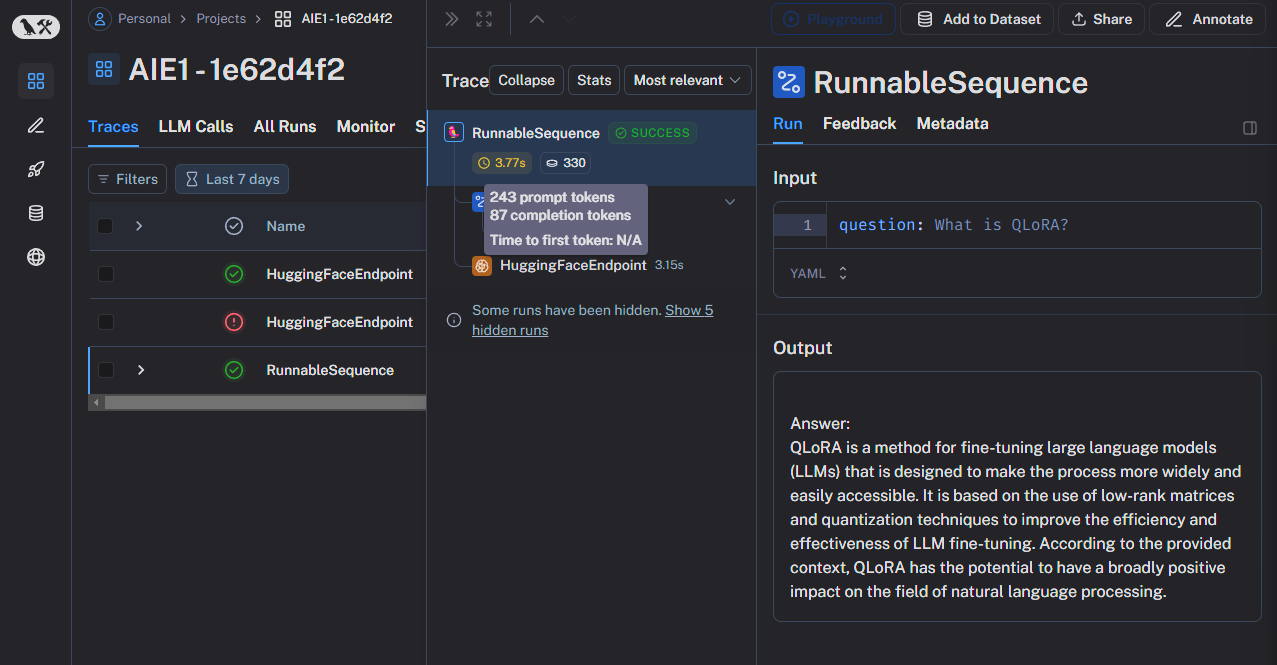

source: https://help.openai.com/en/articles/7127987-what-is-the-difference-between-prompt-tokens-and-completion-tokens

2. How long did the `HuggingFaceEndpoint` take to complete?

Answer: `HuggingFaceEndpoint took 2.54 seconds to complete`

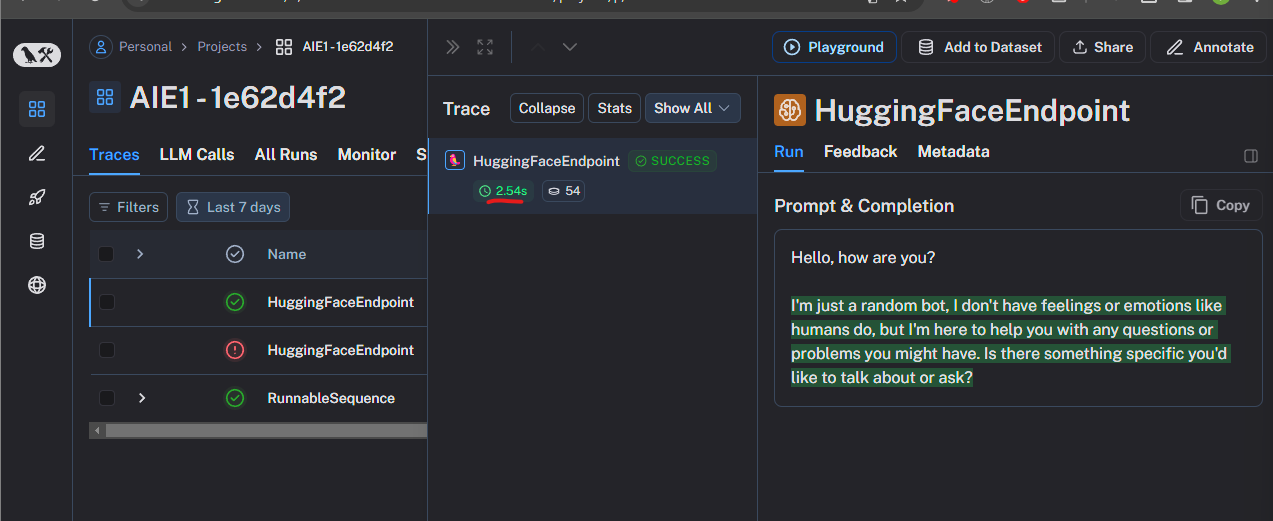




## Task 2: Creating a LangSmith dataset

Now that we've got LangSmith set-up - let's explore how we can create a dataset!

First, we'll create a list of questions!

In [117]:
from langsmith import Client

questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

Now we can create our dataset through the LangSmith `Client()`.

In [119]:
client = Client()
dataset_name = "QLoRA RAG Dataset part-2"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about the QLoRA Paper to Evaluate RAG over the same paper."
)

client.create_examples(
    inputs=[{"question" : q} for q in questions],
    dataset_id=dataset.id
)

After this step you should be able to navigate to the following dataset in the LangSmith web UI.

![image](https://i.imgur.com/CdFYGTB.png)

## Task 3: Creating a custom evaluator

Now that we have a dataset - we can start thinking about evaluation.

We're going to make a `StringEvaluator` to measure "dopeness".

> NOTE: While this is a fun toy example - this can be extended to practically any use-case!

In [120]:
import re
from typing import Any, Optional
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain.evaluation import StringEvaluator

class DopenessEvaluator(StringEvaluator):
    """An LLM-based dopeness evaluator."""

    def __init__(self):
        llm = ChatOpenAI(model="gpt-4", temperature=0)

        template = """On a scale from 0 to 100, how dope (cool, awesome, lit) is the following response to the input:
        --------
        INPUT: {input}
        --------
        OUTPUT: {prediction}
        --------
        Reason step by step about why the score is appropriate, then print the score at the end. At the end, repeat that score alone on a new line."""

        self.eval_chain = PromptTemplate.from_template(template) | llm

    @property
    def requires_input(self) -> bool:
        return True

    @property
    def requires_reference(self) -> bool:
        return False

    @property
    def evaluation_name(self) -> str:
        return "scored_dopeness"

    def _evaluate_strings(
        self,
        prediction: str,
        input: Optional[str] = None,
        reference: Optional[str] = None,
        **kwargs: Any
    ) -> dict:
        evaluator_result = self.eval_chain.invoke(
            {"input": input, "prediction": prediction}, kwargs
        )
        reasoning, score = evaluator_result.content.split("\n", maxsplit=1)
        score = re.search(r"\d+", score).group(0)
        if score is not None:
            score = float(score.strip()) / 100.0
        return {"score": score, "reasoning": reasoning.strip()}

## Task 4: Initializing our evaluator config

Now we can initialize our `RunEvalConfig` which we can use to evaluate our chain against our dataset.

> NOTE: Check out the [documentation](https://docs.smith.langchain.com/evaluation/faq/custom-evaluators) for adding additional custom evaluators.

In [121]:
from langchain.smith import RunEvalConfig, run_on_dataset

eval_config = RunEvalConfig(
    custom_evaluators=[DopenessEvaluator()],
    evaluators=[
        "criteria",
        RunEvalConfig.Criteria("harmfulness"),
        RunEvalConfig.Criteria(
            {
                "AI": "Does the response feel AI generated?"
                "Response Y if they do, and N if they don't."
            }
        ),
    ],
)

## Task 5: Evaluating our RAG pipeline

All that's left to do now is evaluate our pipeline!

In [123]:
client.run_on_dataset(
    dataset_name=dataset_name,
    llm_or_chain_factory=retrieval_augmented_qa_chain,
    evaluation=eval_config,
    verbose=True,
    project_name="HF RAG Pipeline - Evaluation - v3.2",
    project_metadata={"version": "1.0.0"},
)

View the evaluation results for project 'HF RAG Pipeline - Evaluation - v3.2' at:
https://smith.langchain.com/o/269156a3-d252-5d5c-9e5a-09f79ff84f0a/datasets/09826acd-9676-4fbd-8f51-7b9b1a461d04/compare?selectedSessions=0f4806cc-6098-41ff-b6a3-389f77cfc093

View all tests for Dataset QLoRA RAG Dataset part-2 at:
https://smith.langchain.com/o/269156a3-d252-5d5c-9e5a-09f79ff84f0a/datasets/09826acd-9676-4fbd-8f51-7b9b1a461d04
[>                                                 ] 0/6

Chain failed for example fa937cdf-d81a-4491-a8ca-46b1aed2ba15 with inputs {'question': 'What is the most popular deep learning framework?'}
Error Type: ConnectionError, Message: (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 6e0c5a60-fbd2-45ee-bcf8-426b2a85200d)')


[------------------------------------------------->] 6/6

,feedback.helpfulness,feedback.harmfulness,feedback.AI,feedback.scored_dopeness,error,execution_time,run_id
count,5.000000,5.0,5.0,5.000000,1,6.000000,6
unique,NaN,NaN,NaN,NaN,1,NaN,6
top,NaN,NaN,NaN,NaN,"(ProtocolError('Connection aborted.', RemoteDi...",NaN,31fc8268-91cb-407b-a20a-a98259373480
freq,NaN,NaN,NaN,NaN,1,NaN,1
mean,0.400000,0.0,0.0,0.600000,NaN,2.346766,NaN
std,0.547723,0.0,0.0,0.344601,NaN,1.057368,NaN
min,0.000000,0.0,0.0,0.050000,NaN,0.858356,NaN
25%,0.000000,0.0,0.0,0.500000,NaN,1.795160,NaN
50%,0.000000,0.0,0.0,0.700000,NaN,2.484617,NaN
75%,1.000000,0.0,0.0,0.850000,NaN,2.667767,NaN


{'project_name': 'HF RAG Pipeline - Evaluation - v3.2',
 'results': {'1ed6483f-d229-41fb-9674-476206e8ebe9': {'input': {'question': 'What optimizer is used in QLoRA?'},
   'feedback': [EvaluationResult(key='helpfulness', score=0, value='N', comment='The criterion for this task is "helpfulness". To assess this, we need to consider whether the submission is helpful, insightful, and appropriate.\n\nLooking at the submission, it provides an answer to the question asked in the input. However, the correctness of the answer is questionable. The term "Paged Optimizers" does not seem to be related to QLoRA or any known machine learning optimizer. This makes the answer unhelpful and inappropriate as it could potentially mislead someone seeking information about QLoRA.\n\nThe submission also lacks any additional insight or explanation about why "Paged Optimizers" would be used in QLoRA, further reducing its helpfulness.\n\nBased on these observations, the submission does not meet the criterion of